In [ ]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
import pickle

# Constants
IMAGE_SIZE = (128, 128)  # Updated image size to 128x128
BASE_DIR = os.getcwd()  # Dynamically get the current working directory

# Function to load images and label them
def load_images_from_folder(folder, label):
    data = []
    folder_path = os.path.join(BASE_DIR, folder)
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        image = cv2.imread(filepath)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR
            image = cv2.resize(image, IMAGE_SIZE)  # Resize to 128x128
            data.append((image, label))
    return data

# Dataset directories relative to the current working directory
faces_train_folder = "Face_Recognition_DS/Face_Recognition/faces"
faces_test_folder = "Face_Recognition_DS/Face_Recognition/faces_test"
no_faces_train_folder = "Face_Recognition_DS/Face_Recognition/no_faces/linnaeus/Linnaeus 5 128X128/train/all"
no_faces_test_folder = "Face_Recognition_DS/Face_Recognition/no_faces/linnaeus/Linnaeus 5 128X128/test/all"

# Load datasets
faces_train = load_images_from_folder(faces_train_folder, 1)
faces_test = load_images_from_folder(faces_test_folder, 1)
no_faces_train = load_images_from_folder(no_faces_train_folder, 0)
no_faces_test = load_images_from_folder(no_faces_test_folder, 0)

# Combine data and shuffle
train_data = faces_train + no_faces_train
test_data = faces_test + no_faces_test
random.seed(42)  # Ensure reproducibility
random.shuffle(train_data)
random.shuffle(test_data)

# Split into features and labels
X_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])
X_test = np.array([item[0] for item in test_data])
y_test = np.array([item[1] for item in test_data])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Save the datasets as .pkl files
with open(os.path.join(BASE_DIR, "train_data.pkl"), "wb") as f:
    pickle.dump((X_train, y_train), f)

with open(os.path.join(BASE_DIR, "val_data.pkl"), "wb") as f:
    pickle.dump((X_val, y_val), f)

with open(os.path.join(BASE_DIR, "test_data.pkl"), "wb") as f:
    pickle.dump((X_test, y_test), f)

print("Dataset resized to 128x128, labeled, split, and saved.")


Train data: (8796, 128, 128, 3), Validation data: (2199, 128, 128, 3), Test data: (2996, 128, 128, 3)
Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9499 - loss: 0.1145 - val_accuracy: 0.9977 - val_loss: 0.0070
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9976 - loss: 0.0083 - val_accuracy: 0.9973 - val_loss: 0.0078
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9964 - loss: 0.0088 - val_accuracy: 0.9991 - val_loss: 0.0045
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9987 - loss: 0.0058 - val_accuracy: 0.9936 - val_loss: 0.0151
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9937 - loss: 0.0188 - val_accuracy: 0.9955 - val_loss: 0.0146
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9987 - loss: 0.0037 - val_accuracy: 0.9964 - val_loss: 0.0096
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9977 - val_loss: 0

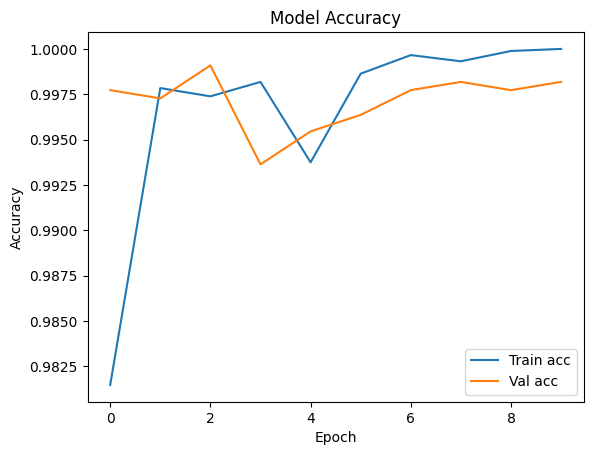

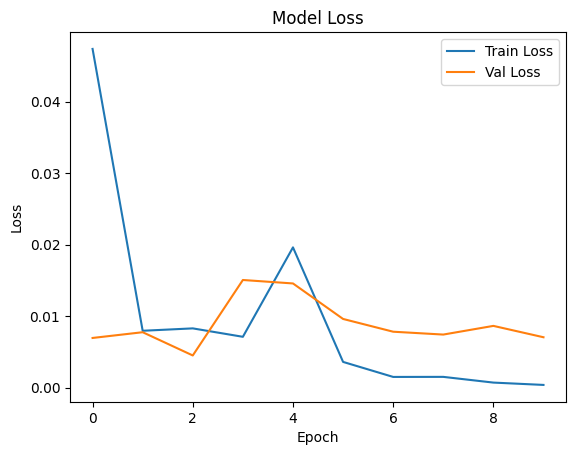

Model opgeslagen als 'face_classifier_model.h5'.


In [30]:
# STAP2

import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16

with open("train_data.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

with open("val_data.pkl", "rb") as f:
    X_val, y_val = pickle.load(f)

with open("test_data.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

print(f"Train data: {X_train.shape}, Validation data: {X_val.shape}, Test data: {X_test.shape}")

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Inputlayer
inputs = layers.Input(shape=(128, 128, 3))

# VGG16 basemodel
x = base_model(inputs)

# Flatten
x = layers.Flatten()(x)

# Fully connected layer
x = layers.Dense(128, activation='relu')(x)

# Dropout for regularization
x = layers.Dropout(0.5)(x)

# Output layer for binary classification
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

import matplotlib.pyplot as plt

# Accuracy plotten
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss plotten
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


model.save("face_classifier_model.h5")
print("Model opgeslagen als 'face_classifier_model.h5'.")












In [4]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 8.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Processing folder: Face_Recognition/faces_test
Processing file: 00011.png
Image dimensions for 00011.png: 128x128


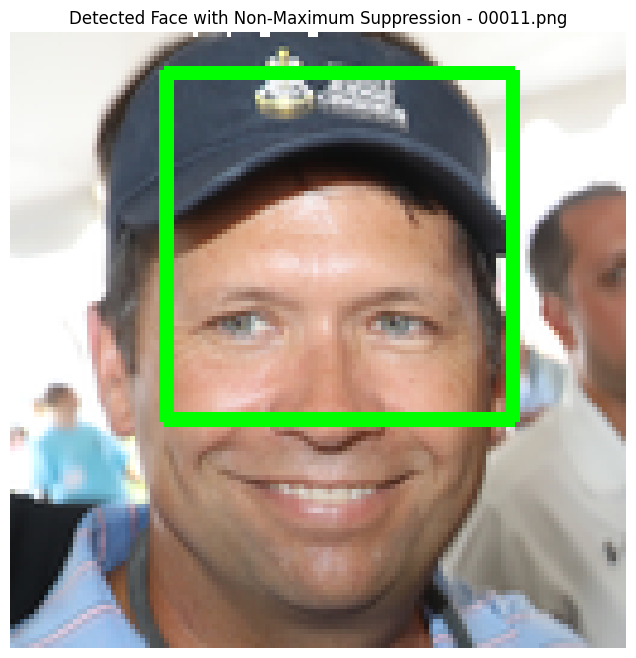

Processing file: 10003.png
Image dimensions for 10003.png: 128x128


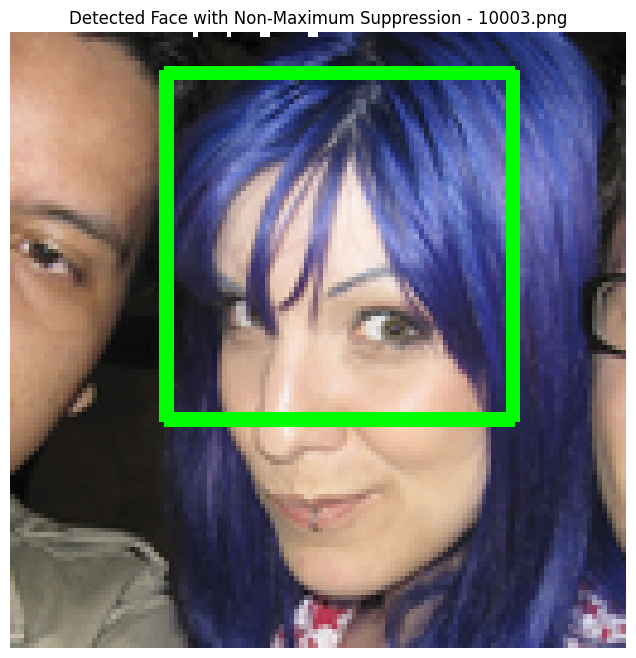

Processing file: 10004.png
Image dimensions for 10004.png: 128x128


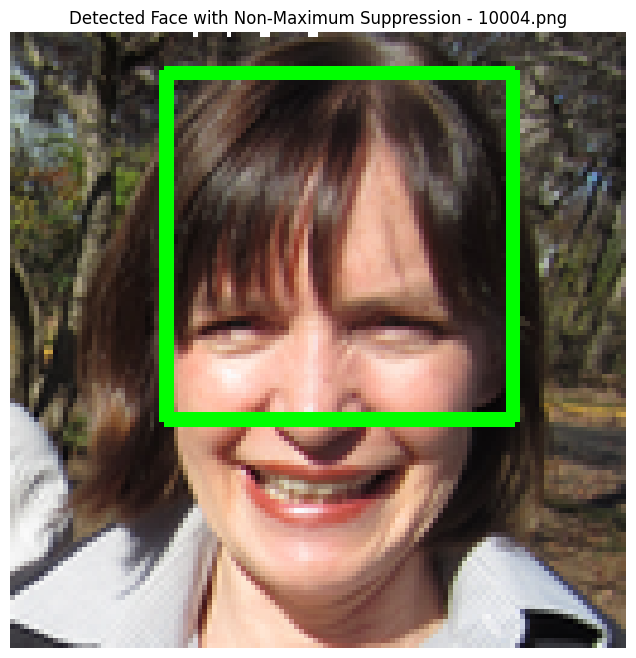

Processing file: 10002.png
Image dimensions for 10002.png: 128x128


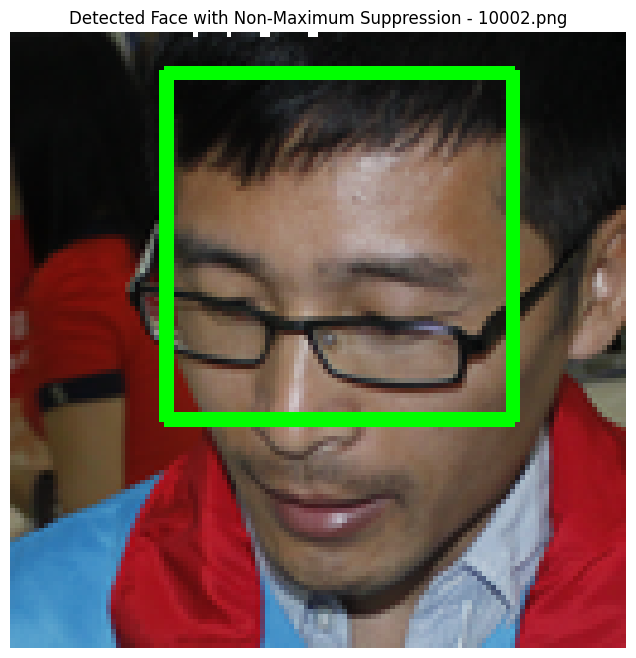

Processing file: 10000.png
Image dimensions for 10000.png: 128x128


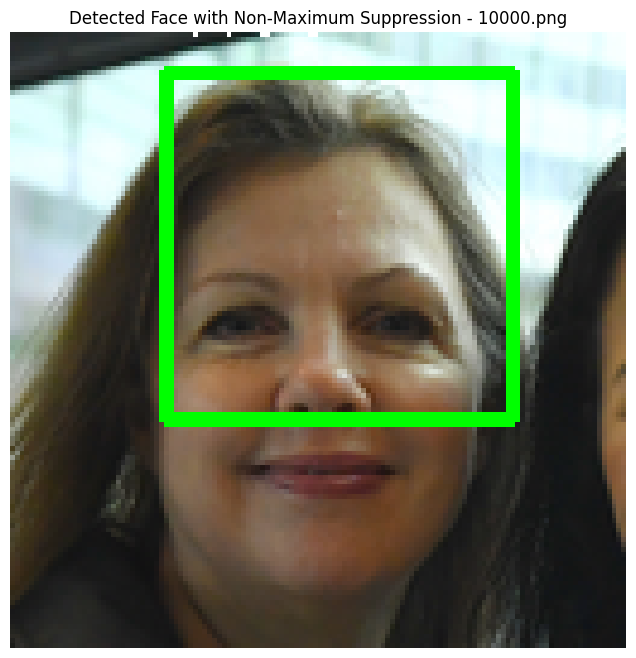

Processing file: 10001.png
Image dimensions for 10001.png: 128x128


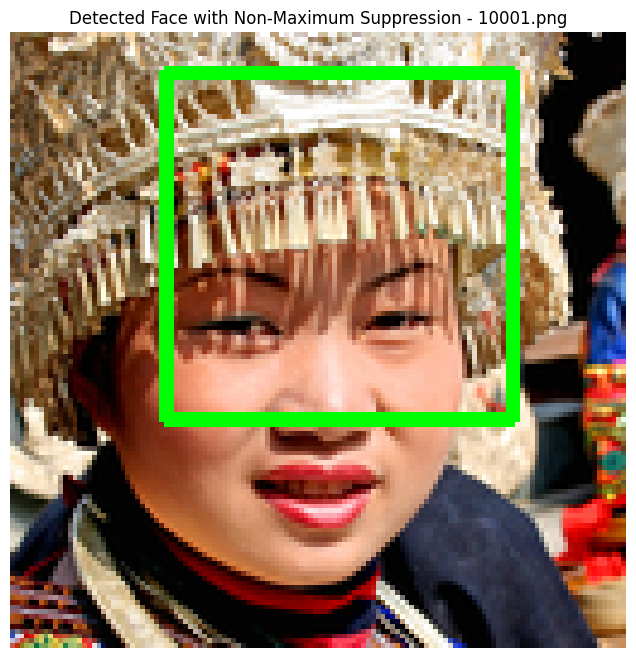

In [56]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model('face_classifier_model.h5')  

test_folder = 'Face_Recognition/faces_test' 

window_size = 128  # De grote van de box
stride = 32        # In hoeveel stappen scannen
threshold = 0.9   # Lowered threshold to detect more faces

# Non-Maximum Suppression (NMS)
def non_max_suppression(boxes, scores, iou_threshold=0.8):  
    if len(boxes) == 0:
        return []

    # Boxes en scores omzetten naar np array
    boxes = np.array(boxes) 
    scores = np.array(scores)

    # Coordinaten van elke bow bepalen
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Oppervlakte box bepalen en score (van hoog naar laag)
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []

    while order.size > 0:
        i = order[0] # Index van box met hoogste score
        keep.append(i)

        # Intersectie coordinaten van huidge box (order[0]) met andere boxen die er nog zijn
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        inter_w = np.maximum(0, xx2 - xx1 + 1)
        inter_h = np.maximum(0, yy2 - yy1 + 1)
        inter_area = inter_w * inter_h

        # IOU berekenen en enkel de boxen behouden met weinig overlap
        iou = inter_area / (areas[i] + areas[order[1:]] - inter_area)
        remaining = np.where(iou <= iou_threshold)[0]
        order = order[remaining] 

    return keep

# Data laden
print(f"Processing folder: {test_folder}")
for filename in os.listdir(test_folder):
    print(f"Processing file: {filename}")
    
    if filename.endswith('.png'):
        img_path = os.path.join(test_folder, filename)
        
        original_image = cv2.imread(img_path)
        if original_image is None:
            print(f"Failed to load image: {img_path}")
            continue

        # Shape va afbeelding
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w, _ = original_image.shape
        
        print(f"Image dimensions for {filename}: {orig_h}x{orig_w}")

        boxes = []
        scores = []

        # Verschillende schalen van de afbeeldingen om verschillende groottes van gezichten te kunnen herkennen
        for scale in [0.5, 1.0, 1.5]:
            scaled_img = cv2.resize(original_image, (int(orig_w * scale), int(orig_h * scale)))
            h, w, _ = scaled_img.shape

        # Sliding window over de afbeelding
            for y in range(0, h - window_size, stride):
                for x in range(0, w - window_size, stride):
                    # Stuk uit de window "knippen"
                    crop = scaled_img[y:y + window_size, x:x + window_size]

                    # Zien dat de window niet uit the image komt, gewoon verder gaan dan
                    if crop.shape[0] != window_size or crop.shape[1] != window_size:
                        continue
                        
                    # Herschalen van afbeelding naar 128x128 
                    resized = cv2.resize(crop, (128, 128)) 
                    
                    # Normalizeren
                    resized = resized / 255.0
                    
                    # Dimensie toevoegen voor model
                    input_img = np.expand_dims(resized, axis=0)
    
                    # Score voorspellen dat er gezicht is in window
                    score = model.predict(input_img, verbose=0)[0][0] #2D array waarbij eerste element score voorspelling
                    
                    # Als de score boven de treshold is, de bounding box toevoegen aan de boxen lijst
                    if score > threshold:
                        boxes.append([x, y, x + window_size, y + window_size])
                        scores.append(score)

        # De NMS functie toepassen om te bepalen welke boxen er overblijven
        keep_indices = non_max_suppression(boxes, scores, iou_threshold=0.8) 
        final_scores = [scores[i] for i in keep_indices]

        # De boxen die overblijven uittekenen
        for (box, score) in zip(final_boxes, final_scores):
            x1, y1, x2, y2 = box

            # Schaling boxes
            margin = 20  # pixels
            x1 = max(x1 - margin, 0)
            y1 = max(y1 - margin, 0)
            x2 = min(x2 + margin, original_image_rgb.shape[1])
            y2 = min(y2 + margin, original_image_rgb.shape[0])
            # Groene box tekenen
            cv2.rectangle(original_image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Score in de box zetten
            cv2.putText(original_image_rgb, f"{score:.2f}", (x1, max(y1 - 10, 0)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Afbeelding tonen met de boxen
        plt.figure(figsize=(8, 8))
        plt.imshow(original_image_rgb)
        plt.title(f"Detected Face with Non-Maximum Suppression - {filename}")
        plt.axis('off')
        plt.show()

